In [36]:
import sklearn.decomposition
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

In [58]:
#tekil değerleri hesaplayın
def self_pca_svd(data,num_of_dims):

    #özvektör sayısı özellik sayısını aşmasın
    assert num_of_dims<=data.shape[1],"dönüştürülen boyut orijinal boyuttan daha küçük olmalıdır"

    #verileri eksi ortalama ile standartlaştırın ve std'ye bölün
    #istatistikteki z skoruna eşdeğerdir
    #scipy.stats.zscore veya sklearn.preprocessing.scale ile eşdeğerdir
    z=np.divide(data-data.mean(axis=0),data.std(axis=0))

    #scipy.linalg.svd hesaplamasının daha hızlı olması gerekiyordu
    #scipy, LAPACK'ın bir paketleyicisidir
    #z puan matrisini iki köşeli forma indirger ve ardından svd'yi çalıştırır
    #np.linalg.eig de LAPACK'ın bir sarmalayıcısı olmasına rağmen
    #böl ve fethet algoritması ile özvektörü hesaplar
    U,D,Vt=scipy.linalg.svd(z)
    
    return U,D,Vt

In [59]:
#fav iris verilerimiz
iris=sklearn.datasets.load_iris()

#Başlangıç durumu
num_of_dims=2

#öz uygulamalarla tutarlılığı korumak için z puanı alın
#iris veri kümesi için bu gereksiz olsa da
#diğer defterlerde bunu hiç yapmadığım için
#bütün özellikler cm cinsinden olduğu için
#birim varyansı gerçekten zarar vermez, değil mi
z=sklearn.preprocessing.StandardScaler().fit_transform(iris.data)

In [60]:
%timeit self_pca_sigma(iris.data,num_of_dims)

78.3 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
#her ne kadar svd'nin daha hızlı olduğu iddia edilse de
#burada durum böyle görünmüyor
#belki gerçekten büyük bir matris için
%timeit self_pca_svd(iris.data,num_of_dims)

185 µs ± 7.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
# uygulama
#teknik olarak, tüm özellikler cm cinsindendir
#birim varyans gerekli değildir
eigvecs_sigma=self_pca_sigma(iris.data,num_of_dims)

#en iyi k özvektörü seçin ve dönüştürün
self_newdims_sigma=z@eigvecs_sigma[:,:num_of_dims]

In [63]:
# uygulama
U,D,Vt=self_pca_svd(iris.data,num_of_dims)

# tekil değerin seçilmesi
self_newdims_svd=z@Vt[:num_of_dims].T

In [65]:
#sklearn
clf=sklearn.decomposition.PCA(num_of_dims)

#transformasyon
skl_newdims=clf.fit_transform(z)

In [66]:
#gördüğünüz gibi, ikinci özvektör ters işarete sahiptir
#andrew ng'i̇n derslerde söyledi̇kleri̇ni̇ hatirladiysaniz
#temel vektör kendi alt uzayında serbestçe dönebilir
#eğer sklearn'deki kodu kontrol ederseniz
#bir yorum "deterministik çıktıyı zorlamak için özvektörlerin işaretini çevirin
print(eigvecs_sigma.T[:num_of_dims])
print(Vt[:num_of_dims])
print(clf.components_)

[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]]
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]]
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]


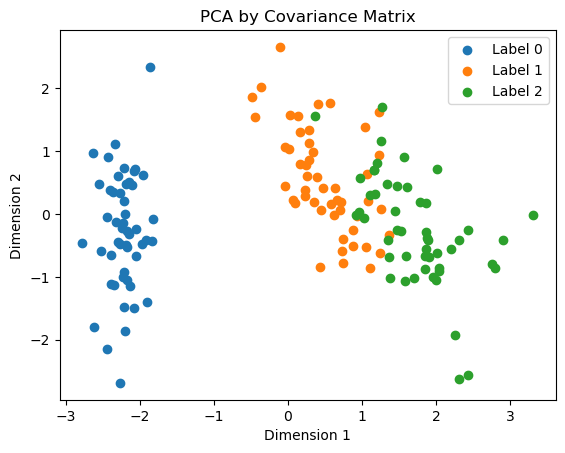

In [67]:
#ikinci özvektörün ters işareti verildiğinde
#viz sklearn ile karşılaştırıldığında dikey olarak çevrilmiş gibi görünüyor
for i in np.unique(iris.target):
    plt.scatter(self_newdims_sigma[:,0][iris.target==i],
                self_newdims_sigma[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('PCA by Covariance Matrix')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc=0)
plt.show()

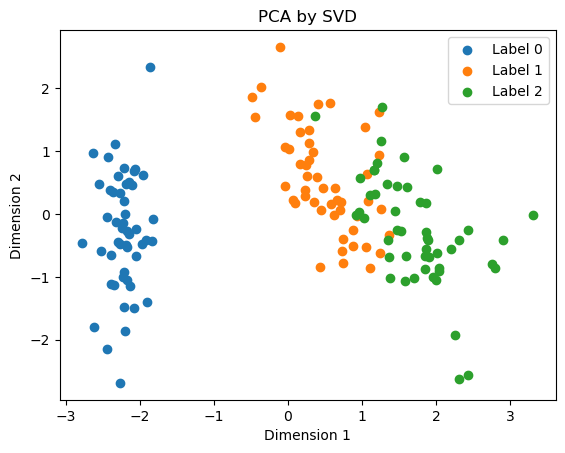

In [68]:
#ikinci öz vektörün ters işareti verildiğinde
#viz sklearn ile karşılaştırıldığında dikey olarak çevrilmiş gibi görünüyor
for i in np.unique(iris.target):
    plt.scatter(self_newdims_svd[:,0][iris.target==i],
                self_newdims_svd[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('PCA by SVD')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc=0)
plt.show()

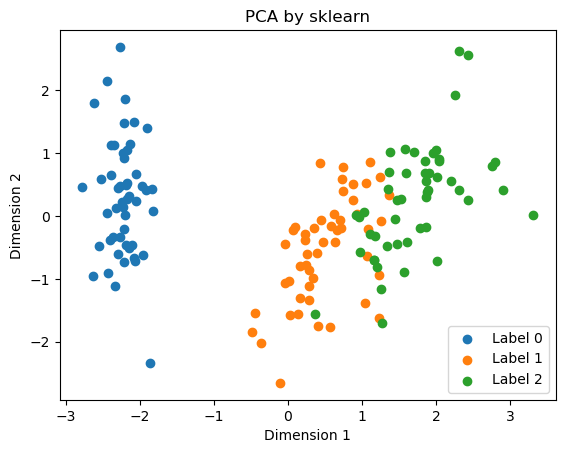

In [69]:
for i in np.unique(iris.target):
    plt.scatter(skl_newdims[:,0][iris.target==i],
                skl_newdims[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('PCA by sklearn')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc=0)
plt.show()

**Optimum Bileşen Sayısı**

Optimum bileşen sayısı PCA'nın kendisi kadar kolaydır. Bizim durumumuzda, sadece 2D görselleştirme yapmak istediğimiz için sayıyı zaten biliyoruz. Daha genel bir boyut azaltma durumu için en uygun sayı, açıklanan varyans (R kare) tarafından belirlenir. Bir eşik belirleriz (istatistikte genellikle %95) ve varyansın en az %95'ini açıklayacak minimum bileşen sayısını buluruz.

In [70]:
#Açıklanan varyansı regresyondaki r kare olarak düşünebilirsiniz
#hesaplama esasen karesel regresyonun toplamıdır
#karesel hataların 1 toplamına/karesel toplamın karesine eşdeğerdir
def explained_variance_general(data,newdims,eigvecs):

    miu=data.mean(axis=0)
    result=[]
    for i in range(newdims.shape[1]):
        
        #projeksiyon ve bileşenlere göre tahmin oluşturun
        #Bileşenler ortogonal olduğu için
        #ortogonal bir matrisin tersi onun transpozesidir
        #izdüşüm, ötelenmiş bir bileşenin çarpılmasıyla geri döndürülebilir
        #ve standart önişleme olduğu için miu ekleyin
        #eğer seni daha iyi hissettirecekse
        #u kovaryans matrisini de çarpabilir
        inversed=newdims[:,i].reshape(-1,1)@eigvecs[i].reshape(1,-1)+miu
        
        #sum of squared errors
        numerator=np.diag((inversed-data).T@(inversed-data)).sum()**0.5
        
        #sum of squared total
        denominator=np.diag((data-miu).T@(data-miu)).sum()**0.5
        
        #r squared
        result.append(1-(numerator/denominator)**2)
        
    return result

In [71]:
#TDA verimli olduğu kadar açıklanmış varyans hesaplaması için de uygundur
#Açıklanan standart sapma yalnızca D'nin köşegenindedir 
#karesi alınmış tekil değerleri alır ve açıklanmış varyansı elde ederiz
def explained_variance_svd(data,D,num_of_dims):    
    return (D**2)[:num_of_dims]/(D**2).sum()

In [72]:
#üç yöntemin açıklanan varyansı tutarlıdır
print(explained_variance_general(z,self_newdims_sigma,
                                 eigvecs_sigma.T[:num_of_dims]))

print(explained_variance_svd(z,D,num_of_dims))

print(clf.explained_variance_ratio_)

[0.7296244541329987, 0.22850761786701768]
[0.72962445 0.22850762]
[0.72962445 0.22850762]


In [73]:
#optimal sayı kavramını göstermek için
#örnek olarak TDA'yi alıyoruz
#sadece r kare hesaplaması basit olduğu için
rsquared=[]
threshold=0.95

#bileşen sayısı özellik sayısını aşamaz
for num_of_dims in range(1,iris.data.shape[1]+1):
    U,D,Vt=self_pca_svd(iris.data,num_of_dims)
    self_newdims_svd=z@Vt[:num_of_dims].T
    rsquared.append(sum(explained_variance_svd(z,D,num_of_dims)))

In [74]:
#optimumu bulmak
optima=[i for i in rsquared if i>threshold][0]
ind=rsquared.index(optima)+1

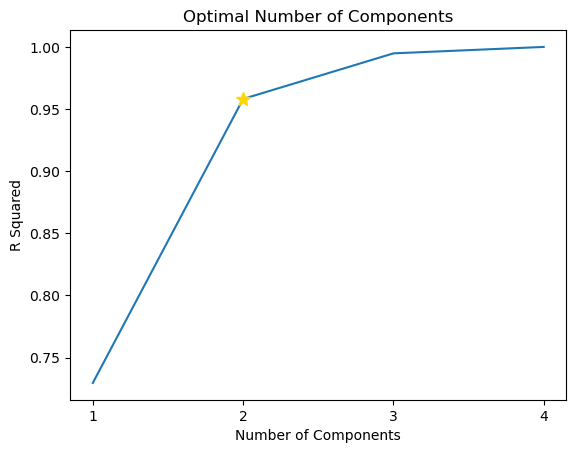

In [75]:
#viz
plt.plot(range(1,iris.data.shape[1]+1),rsquared)
plt.plot([ind],[optima],lw=0,marker='*',markersize=10,color='gold') 
plt.xticks(range(1,iris.data.shape[1]+1))
plt.title('Optimal Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R Squared')
plt.show()

**Düşük Sıralama / Derece Yaklaşımı**

SVD'den bahsettiğimize göre, düşük sıra yaklaşımı adı verilen başka bir veri sıkıştırma tekniğinden bahsetmek zararsızdır. Bu teknik mutlaka veri boyutunu azaltmaz ancak temel bileşenleri koruyarak veri kümesinin varyansını azaltır. PCA genellikle frobenius normunda düşük sıra yaklaşımı olarak düşünülür. 

Teknik basittir. Bir SVD, dış çarpım açılımları olarak adlandırılan vektörlerin doğrusal bir kombinasyonu olarak ifade edilebilir. Kaç tane özvektörün dikkate alınacağına karar vermek bize kalmıştır.

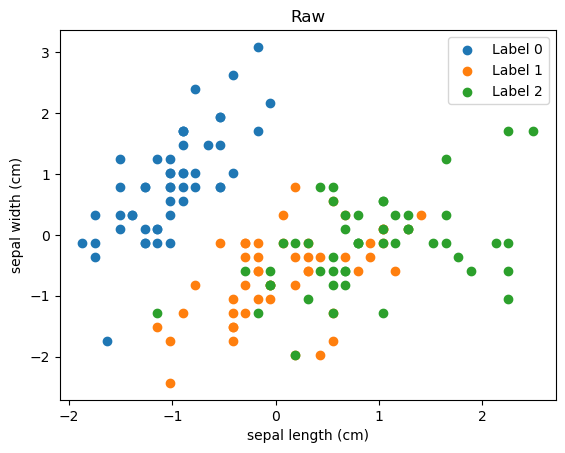

In [76]:
#karşılaştırma için kontrol grubu
for i in np.unique(iris.target):
    plt.scatter(z[:,0][iris.target==i],
                z[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('Raw')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(loc=0)
plt.show()

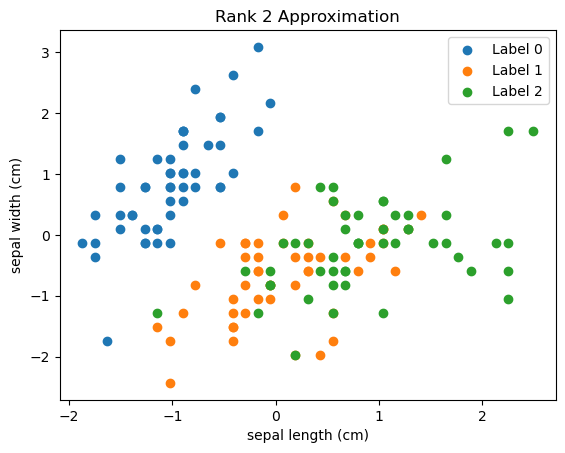

In [77]:
#2 özvektör %95,8 varyansı açıklayabilir
#matris fazla sıkıştırılmamış
rank2=np.sum([(U[:,i].reshape(-1,1))@(Vt[i].reshape(1,-1))*D[i] for i in range(num_of_dims)],axis=0)

for i in np.unique(iris.target):
    plt.scatter(rank2[:,0][iris.target==i],
                rank2[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('Rank 2 Approximation')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(loc=0)
plt.show()

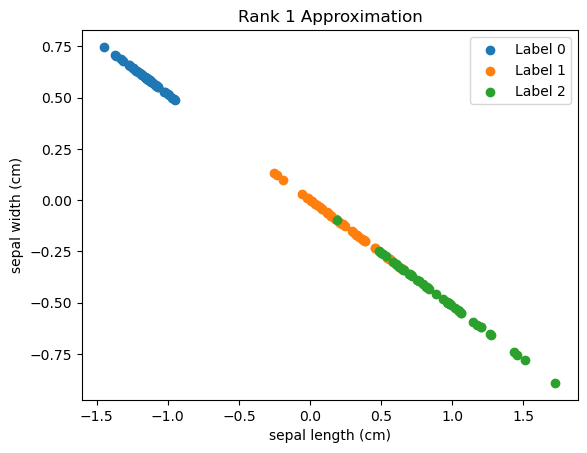

In [78]:
#1. özvektör %72,7 varyansı açıklayabilir
#matris çok sıkıştırıldı
#şimdi 1 boyutlu pca gibi görünüyor, değil mi?
rank1=np.sum([(U[:,i].reshape(-1,1))@(Vt[i].reshape(1,-1))*D[i] for i in range(1)],axis=0)

for i in np.unique(iris.target):
    plt.scatter(rank1[:,0][iris.target==i],
                rank1[:,1][iris.target==i],
                label=f'Label {int(i)}')
    
plt.title('Rank 1 Approximation')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(loc=0)
plt.show()